In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems, SSMCMain.ModifiedMiCRM.GraphAnalysis

In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables
using Graphs, Clustering
using MetaGraphsNext
using StatsBase

In [3]:
using CairoMakie
using GLMakie
GLMakie.activate!()
# display(GLMakie.Screen(), f.figure)

In [ ]:
function make_eflowgraph_KS(ps, ss;
    clamp_zero=false,
    default_weight=0.
)
    Ns, Nr = get_Ns(ps)

    if clamp_zero
        ss = clamp_ss(ss)
    end

    mg = MetaGraph(
        DiGraph();
        label_type=FGNodeType,
        vertex_data_type=@NamedTuple{name::String, val::Float64, desc::String},
        edge_data_type=Float64,
        graph_data=(;
            Ns, Nr, ps, ss
        ),
        weight_function=identity,
        default_weight,
    )

    # first add
    mg[Source()] = (; name="Source", val=1.0, desc="source")
    mg[Sink()] = (; name="Sink", val=-Inf, desc="sink")
    for i in 1:Ns
        mg[S(i)] = (
            name="N_$i",
            val=ss[i] / ps.g[i],
            desc="strain $i"
        )
    end
    for a in 1:Nr
        mg[R(a)] = (
            name="R_$a",
            val=ss[Ns+a] * ps.w[a],
            desc="resource $a"
        )
    end

    # add edges to/from the Sink/Source
    for a in 1:Nr
        K = ps.K[a] * ps.w[a]
        if !iszero(K)
            # Note that the source value is set to 1
            mg[Source(), R(a)] = K
        end
        mg[R(a), Sink()] = ps.r[a] * mg[R(a)].val
    end

    for i in 1:Ns
        mg[S(i), Sink()] = ps.m[i] * ss[i]
    end

    # add the metabolic edges, the complex bit
    for i in 1:Ns
        for a in 1:Nr
            c = ps.c[i, a]
            
            C = ss[i] * ps.c[i, a] * ss[Ns+a] * ps.w[a]
            mg[R(a), S(i)] = C
        
            
            l = ps.l[i, a]
            if !iszero(l)
                sum_of_Ds = 0.0
                for b in 1:Nr
                    D = ps.D[i, a, b]
                    if !iszero(D)
                        sum_of_Ds += D

                        kk = l * D * C
                        s = S(i)
                        d = R(b)
                        if haskey(mg, s, d)
                            mg[s, d] = kk + mg[s, d]
                        else
                            mg[s, d] = kk
                        end
                    end
                end
                if sum_of_Ds < 1.0
                    mg[S(i), Sink()] += l * (1 - sum_of_Ds) * C
                end
            end
        end
    end

    mg
end
export make_eflowgraph_KS

## First, let's make a network to test

In [4]:
import Base: copy

struct LinstabScanTester_SAR{F}
    ks::Vector{F}
    M1::Matrix{F}
    M::Matrix{F}
    threshold::F
    function LinstabScanTester_SAR(ks, N, threshold=2 * eps())
        M1 = Matrix{eltype(ks)}(undef, N, N)
        M = Matrix{eltype(ks)}(undef, N, N)
        new{eltype(ks)}(ks, M1, M, threshold)
    end
end
function LinstabScanTester_SAR(ks, p::AbstractMMiCRMParams, threshold=2 * eps())
    LinstabScanTester(ks, sum(get_Ns(p)), threshold)
end
function (lt::LinstabScanTester_SAR)(sp::AbstractSMMiCRMParams, ss)
    make_M1!(lt.M1, sp, ss)

    evals = eigvals(lt.M1)
    if any(l -> real(l) > 0., evals)
        return -1
    end

    for k in lt.ks
        lt.M .= lt.M1
        M1_to_M!(lt.M, get_Ds(sp), k)
        evals = eigvals!(lt.M)
        if any(l -> real(l) > lt.threshold, evals)
            return 1
        end
    end
    return 2
end
function copy(lst::LinstabScanTester_SAR)
    LinstabScanTester_SAR(lst.ks, size(lst.M)[1], lst.threshold)
end

copy (generic function with 470 methods)

In [5]:
# can add a copy of example_do_rg_run if we need more flexibility
function do_rg_run(rg, num_repeats, ks;
    extinctthreshold=1e-8,
    maxresidthreshold=1e-9,
    linstabthreshold=100 * eps(),
    return_interesting=false
)
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester_SAR(ks, N, linstabthreshold)

    rslts = fill(0, num_repeats)
    interesting_systems = []

    @tasks for i in 1:num_repeats
        @local llst = copy(lst)

        params = rg()

        result = 0
        interesting = false

        # numerically solve for the steady state
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0)
        ssps = solve(ssp, DynamicSS(QNDF());
            reltol=maxresidthreshold,
            #isoutofdomain=(u,_,_)-> any(x -> x < 0., u),
            maxiters=1000000
        )

        if SciMLBase.successful_retcode(ssps.retcode)
            warning = false
            maxresid = maximum(abs, ssps.resid)
            if maxresid > maxresidthreshold * 100
                @warn (@sprintf "maxresid reached is %g which is close to %g" maxresid (maxresidthreshold * 100))
                warning = true
            end

            if all(x -> abs(x) < extinctthreshold, ssps.u[1:Ns])
                result = -101 # gone extinct in nospace ss
            end

            linstab_result = llst(params, ssps.u)
            if !warning
                if linstab_result == 1
                    result = 2 # spatial instability
                    interesting = true
                elseif linstab_result == 2
                    result = 1 # stable
                else
                    result = 3 # stable but may be wrong
                end
            else
                if linstab_result == 1
                    result = -2 # spatial instability but may be wrong
                elseif linstab_result == 2
                    result = -1 # stable but may be wrong
                else
                    result = -3 # stable but may be wrong
                end
            end
        else
            result = -100
        end

        rslts[i] = result
        if return_interesting && interesting
            push!(interesting_systems, params)
        end

        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    if !return_interesting
        rslts
    else
        rslts, interesting_systems
    end
end

do_rg_run (generic function with 1 method)

In [6]:
function do_rg_run2(rg, num_repeats, kmax, Nks;
    maxresidthr=1e-7,            # will warn if ss residues are larger than this
    errmaxresidthr=1e6 * maxresidthr, # if above this will return error code
    extinctthr=maxresidthr / 10, # species below this value are considered extinct
    lszerothr=100 * eps(),      # values +- this are considered 0 in linstab analysis
    lspeakthr=lszerothr,
    # whether and which params to return for further examination (int <-> interesting)
    return_int=nothing,
    return_int_sss=true,
    # ss solver setup
    ode_solver=Rodas4(),
    tol=maxresidthr / 10,
    timelimit=nothing, # time limit for one solver run in seconds
    abstol=tol,
    reltol=tol,
    maxiters=100000,
    # passed to make_mmicrm_ss_problem
    kwargs...
)
    sample_params = rg()
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # handle interesting systems setup
    int_func = if isnothing(return_int)
        nothing
    elseif isa(return_int, Vector) || isa(return_int, Tuple)
        c -> c in return_int
    elseif isa(return_int, Function)
        return_int
    elseif return_int == :all
        c -> true
    else
        throw(ArgumentError("return_interesting needs to be either a list of codes or a custom function"))
    end

    solver_kwargs = (; maxiters, abstol, reltol)
    if !isnothing(timelimit)
        solver_kwargs = (; solver_kwargs..., callback=make_timer_callback(timelimit))
    end

    # setup ks for linstab analysis
    ks = LinRange(0.0, kmax, Nks)[2:end] # 0 is handled separately

    # setup the returned data containers
    rslts = fill(0, num_repeats)

    # these may not be used, skipping the if to not have them boxed
    int_lock = ReentrantLock()
    int_systems_to_return = typeof(sample_params)[]
    int_systems_sss = Vector{Float64}[]

    # the core of the function
    @localize solver_kwargs @tasks for i in 1:num_repeats
        # Prealloc variables in each thread (task)
        @local begin
            M1 = Matrix{Float64}(undef, N, N)
            M = Matrix{Float64}(undef, N, N)
            mrls = Vector{Float64}(undef, length(ks))
        end

        # Setup one random system
        params = rg()
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0; kwargs...)
        result = 0
        warning = false

        ######################################## 

        # numerically solve for the steady state
        ssps = solve(ssp, DynamicSS(ode_solver);
            isoutofdomain=(u,_,_)-> any(x -> x < 0., u), solver_kwargs...)

        # Check the solver
        if !SciMLBase.successful_retcode(ssps.retcode)
            result = -1000 # solver failed return code
            result -= Int(ssps.original.retcode)
            if ssps.original.retcode == ReturnCode.MaxTime
                @warn "Solver quit due to time limit being reached"
                flush(stderr)
            end
            @goto handle_result
        end
        # Check that the steady state is steady enough
        maxresid = maximum(abs, ssps.resid)
        if maxresid > errmaxresidthr
            @warn (@sprintf "maxresid reached is %g which is above the error threshold of %g" maxresid maxresidthr)
            result = -2000 # maxresid is way beyond any reasonable values
            @goto handle_result
        elseif maxresid > maxresidthr
            @warn (@sprintf "maxresid reached is %g > %g" maxresid maxresidthr)
            warning = true
        end

        # Check for a full extinction
        if all(x -> abs(x) < extinctthr, ssps.u[1:Ns])
            result = 101 # gone extinct in nospace ss
            @goto handle_result
        end

        # Do linear stability

        # handle the k=0 case
        make_M1!(M1, params, ssps.u)
        k0mrl = maximum(real, eigvals!(M1))

        # calculate mrls
        make_M1!(M1, params, ssps.u)
        for (ki, k) in enumerate(ks)
            M .= M1
            M1_to_M!(M, get_Ds(params), k)
            evals = eigvals!(M)
            mrls[ki] = maximum(real, evals)
        end

        # evaluate the mrl results
        maxmrl, maxi = findmax(mrls)

        if k0mrl < -lszerothr # this is the ideal case
            if maxmrl < -lspeakthr
                result = 1
                @goto handle_result
            else
                result = 2
                @goto handle_result
            end
        elseif k0mrl < lszerothr # this can happen when there are interchangeable species, or when close to numerical issues
            if maxmrl < -lspeakthr
                result = 11
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated # k0 is sketchy but we have a separated positive peak
                    result = 12
                    @goto handle_result
                else # the largest peak is connected to a positive k0 - clearly messy
                    result = 13
                    @goto handle_result
                end
            end
        else # something is definitely off here, however still do the same analysis for extra info
            if maxmrl < lspeakthr
                result = 21
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated
                    result = 22
                    @goto handle_result
                else
                    result = 23
                    @goto handle_result
                end
            end
        end

        ######################################## 

        @label handle_result
        if warning
            result *= -1
        end
        rslts[i] = result
        if !isnothing(int_func) && int_func(result)
            lock(int_lock) do
                push!(int_systems_to_return, params)
                if return_int_sss
                    push!(int_systems_sss, ssps.u)
                end
            end
        end
    end

    if isnothing(int_func)
        rslts
    else
        if !return_int_sss
            rslts, int_systems_to_return
        else
            rslts, int_systems_to_return, int_systems_sss
        end
    end
end


do_rg_run2 (generic function with 1 method)

In [7]:
function func(N, R, lm, lc, ll, lsi, lsr, lsb,Ds=1e-10, Dr=1)
        total_influx = 1.0 * R # setting E (or E/V)
        Kmean = total_influx / (lsi * R)
        K = (Kmean, Kmean * sigma_to_mu_ratio1())

        RSGJans1(N, R;
            m=(lm, lm * sigma_to_mu_ratio1()),
            r=1.0, # setting T
            sparsity_influx=lsi,
            K,
            sparsity_resources=lsr,
            sparsity_byproducts=lsb,
            c=(lc, lc * sigma_to_mu_ratio1()),
            l=(ll, ll * sigma_to_mu_ratio1()),
            Ds, Dr # diffusions passed through
        )
end

func (generic function with 3 methods)

In [8]:
function chemostat_dependence(ps,ss)
    # Calculate the chemostat dependence of a system
    pct_chem = fill(0.0,length(ss))

    # make the graph
    g = make_eflowgraph_KS(ps, ss; clamp_zero=true)
    weights = Graphs.weights(g)

    chemostat_neighbors = all_neighbors(g, 1)

    for n in 3:2+length(ss)
        neighbors = all_neighbors(g, n)

        # sum all of the edges coming in and going out of the node
        external_influx = sum(weights[nei, n] for nei in chemostat_neighbors)
        total_influx = sum(weights[nei, n] for nei in neighbors)

        if total_influx != 0
            pct_chem[n-2] = external_influx / total_influx
        else
            pct_chem[n-2] = 0.0
        end

    end

    return pct_chem

end

chemostat_dependence (generic function with 1 method)

In [9]:
function shannon_entropy(abundances)
    # Shannon entropy
    n = sum(abundances)
    -sum((f / n) * log2(f / n) for f in abundances if f > 0)
end

shannon_entropy (generic function with 1 method)

In [10]:
function outflux_diversity(ps, ss)
    # Calculate the outflux diversity of a system
    out_divr = fill(0.0,length(ss))

    # make the graph
    g = make_eflowgraph_KS(ps, ss; clamp_zero=true)
    weights = Graphs.weights(g)

    for n in 3:2+length(ss)

        # make a list of all of the output edges and calculate shannon entropy
        out_edges = [nei for nei in all_neighbors(g, n) if nei != 1]
        out_divr[n-2] = shannon_entropy(weights[n, out_edges])

    end
    return out_divr

end

outflux_diversity (generic function with 1 method)

In [11]:
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end


sigma_to_mu_ratio1 (generic function with 1 method)

In [12]:
N = R = 10
retain = (2, ) # interesting results to return

rsg = func(N,R,0.2, 2, 0.9, 0.1, 0.3, 0.3)

xx,prms,sses = do_rg_run2(rsg, 100, 50,1000;
    maxresidthr=1e-8,
    tol=1e-11,
    return_int=retain
)

freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼───
1     │ 85
2     │  8
101   │  7

In [68]:
# here is one unstable system
ss = sses[1]
ps = prms[1]

BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.3219877751167258, 0.2477036417281268, 0.22277086063983356, 0.16562025253391185, 0.22300023431518803, 0.18686906909628, 0.08540673568609704, 0.17399556062058041, 0.1309448181632499, 0.12965609243475487], [0.0, 0.0, 14.331692272106977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.7090411721266623; … ; 0.0 1.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.5372052229155744], [1.867988706488141 1.716250354957108 … 0.0 0.0; 1.4801373705632799 0.0 … 0.0 2.093459578763401; … ; 0.0 1.4874837109917594 … 0.0 2.4401158967960703; 0.0 0.0 … 0.0 1.8554424852547422], [0.0 0.0 … 0.481385506281997 0.0004922889556741478; 0.0 0.1759714951494317 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.47190416066396645 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [69]:
# get the PDE solution to compare to
final_sol, average = run_pde(ps, ss,true)

spaceps.usenthreads = 6
spaceps.mmicrm_params.usenthreads = nothing
Final solution size: (20, 1000)
system size: (1000,)
1000
average shape: (20, 1)
Average abundance: [6.286103416241417e-90; 1.547784010202248e-75; -1.633676452039411e-79; -5.326508605390648e-71; 7.733810755863383; 4.864566564061767e-76; 1.8113192815431984; 10.200131431683285; -3.112067250112548e-76; 28.35559744510716; 0.624458106262505; 0.03505179854972178; 1.7218134356324375; 0.006244316752612364; 4.102740514352326; 0.05762894791487754; 1.9287288774959538e-68; 0.01159636090877912; 0.2935715505960442; 0.14799321306293772;;]


([6.2046768862630825e-90 5.95181128391716e-90 … 6.1465593422605065e-90 6.061435379125015e-90; 5.4228458266977005e-76 5.089214796192271e-76 … 3.4370570865560334e-76 4.006356276770328e-76; … ; 0.2967596187751881 0.2961602372326677 … 0.2980474727410592 0.29738867627970444; 0.14959930912272518 0.14929712831061098 … 0.15024858241527667 0.14991644986591932], [6.286103416241417e-90; 1.547784010202248e-75; … ; 0.2935715505960442; 0.14799321306293772;;])

In [70]:
function biomass_change_correlation(average, hss)
    # Calculate the biomass correlation
    S = length(average)
    diff = raw_difference(average, hss)
    corr = zeros(Float64, S, S)

    for i in 1:S
        for j in 1:S
            corr[i, j] = (diff[i] - diff[j]) / (diff[i] + diff[j])
        end
    end
end

biomass_change_correlation (generic function with 1 method)

In [71]:
# filter the strains that are extinct
spat_corr = spatial_correlation(final_sol)


20×20 Matrix{Float64}:
  1.0         0.0551922    0.0354765  …   0.070347     0.0704486
  0.0551922   1.0         -0.0409407      0.00759217   0.00750697
  0.0354765  -0.0409407    1.0            0.201979     0.202375
 -0.054855    0.726016    -0.329554      -0.103507    -0.103681
 -0.0182823  -0.0494896    0.173608       0.285395     0.287894
  0.0326041   0.0836938   -0.745933   …  -0.207317    -0.207614
 -0.0183696  -0.0497567    0.174062       0.286943     0.28944
 -0.0182967  -0.0495301    0.17369        0.285669     0.288167
 -0.0326897  -0.00760171  -0.0272429      0.00875967   0.00878324
 -0.0183104  -0.0495571    0.173769       0.285937     0.288435
  0.0703799   0.00762331   0.201905   …   0.999999     0.999993
  0.0703814   0.00762458   0.201896       0.999999     0.999993
 -0.0703823  -0.00762023  -0.201914      -0.999999    -0.999993
  0.0703833   0.00764849   0.201837       0.999998     0.99999
  0.0703825   0.00762094   0.201912       0.999999     0.999993
  0.0704061   

In [72]:
# start with a graph
g = make_eflowgraph_KS(ps, ss;
    clamp_zero=true)



Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type FGNodeType, vertex metadata of type @NamedTuple{name::String, val::Float64, desc::String}, edge metadata of type Float64, graph metadata given by (Ns = 10, Nr = 10, ps = BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.3219877751167258, 0.2477036417281268, 0.22277086063983356, 0.16562025253391185, 0.22300023431518803, 0.18686906909628, 0.08540673568609704, 0.17399556062058041, 0.1309448181632499, 0.12965609243475487], [0.0, 0.0, 14.331692272106977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0 1.0 0.0 0.0 0.0 0.0 0.7926535732099118 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0 0.0 0.7933671247495521 0.0 0.0 0.7090411721266623; 0.0 1.0 0.0 0.0 0.0 0.6885672579805769 0.0 0.9770588095960536 0.0 0.0; 0.0 0.0 0.0 0.8647679309227639 0.0 0.0 0.85127813

In [15]:
# I am lowkey frustrated by the graph packages in Julia, so I am going to write my own Markov path cycle rank algorithm
# first we will test it outside of a function

# define a node of interest
parent_node = 18
sink_node = 2

n_rep = 100

min_energies = Set{Float64}()
cycle_lengths = Set{Int}()

for w in 1:n_rep


    current_node = parent_node

    # graph weights
    wts = Graphs.weights(g)

    # keep track of the visited nodes
    visited = Set{Int}()
    # keep track of the edge weights
    visited_weights = Set{Float64}()

    # see if we have gotten back 
    rtrn = false

    natt = 0

    while !rtrn
        # get the neighbors of the node
        neighbors = all_neighbors(g, current_node)

        # get the weights of the edges to the neighbors
        adjacent_weights = [wts[current_node, n] for n in neighbors]
        adjacent_probabilities = adjacent_weights ./ sum(adjacent_weights)
        #println(adjacent_probabilities)

        # sample the next node based on the edge weights
        successfully_sampled = false
        next_node = 0
        while !successfully_sampled
            nn = sample(neighbors, Weights(adjacent_probabilities))
            if nn != sink_node
                successfully_sampled = true
                next_node = nn
            end
        end 

        #println("Current node: $current_node, Next node: $next_node")

        # mark the current node as visited and record the weight
        push!(visited, current_node)
        push!(visited_weights, wts[current_node, next_node])

        # move to the next node
        current_node = next_node

        #println("moving to node: $current_node")

        # check if we have returned to the parent node
        if current_node == parent_node
            rtrn = true
        end
        natt += 1
        if natt > 10000
            println("Too many iterations, breaking out of the loop")
            println("Visited nodes: ", visited)
            println("Visited weights: ", visited_weights)
            println("Current node: ", current_node)
            println("Parent node: ", parent_node)
            break
        end
    end

    min_energy = minimum(visited_weights)
    push!(min_energies, min_energy)

    # calculate the cycle length
    cycle_length = length(visited)
    push!(cycle_lengths, cycle_length)
end

min_energies = collect(min_energies)
cycle_lengths = collect(cycle_lengths)

val, indx = findmax(min_energies)
println(val)

println("maximum cycle limiting energy: ", val)
println(min_energies[indx])
println("maximum energy cycle length: ", cycle_lengths[indx])


Too many iterations, breaking out of the loop
Visited nodes: Set([13, 16, 7, 15, 10, 18])
Visited weights: Set([4.693752085593042, 17.332297033358206, 2.805218172414119, 12.018071499435647, 0.11397555261989058, 0.1291456365766486, 1.0188489001079393, 4.626531601068039])
Current node: 7
Parent node: 18
Too many iterations, breaking out of the loop
Visited nodes: Set([13, 16, 7, 15, 10, 18])
Visited weights: Set([4.693752085593042, 17.332297033358206, 2.805218172414119, 12.018071499435647, 0.11397555261989058, 1.0188489001079393, 4.626531601068039])
Current node: 7
Parent node: 18
Too many iterations, breaking out of the loop
Visited nodes: Set([13, 16, 7, 15, 10, 18])
Visited weights: Set([4.693752085593042, 17.332297033358206, 2.805218172414119, 12.018071499435647, 0.11397555261989058, 1.0188489001079393, 4.626531601068039])
Current node: 7
Parent node: 18
Too many iterations, breaking out of the loop
Visited nodes: Set([13, 16, 7, 15, 10, 18])
Visited weights: Set([4.693752085593042, 

In [73]:
function mc_step(loc,g,wts)
    # perform a single Markov step
    # loc is the current location
    # g is the graph
    # wts are the weights of the edges

    neighbors = all_neighbors(g, loc)
    adjacent_weights = [wts[loc, n] for n in neighbors]
    adjacent_probabilities = adjacent_weights ./ sum(adjacent_weights)

    # sample the next node based on the edge weights
    next_node = sample(neighbors, Weights(adjacent_probabilities))
    wt = wts[loc, next_node]

    return next_node, wt
end

mc_step (generic function with 1 method)

In [84]:
function walker_journey(g,wts, parent_node,sink_node)
    visited = Vector{Int}()
    visited_weights = Vector{Float64}()
    current_node = parent_node
    rtrn = false
    snk = false
    append!(visited, current_node)


    while !rtrn && !snk

        nn, wt = mc_step(current_node, g, wts)
        current_node = nn
        
        if current_node == sink_node
            snk = true
        end

        if current_node > N+2 && current_node in visited
            rtrn = true
        end

        append!(visited, nn)
        append!(visited_weights, wt)

    end

    return visited, visited_weights, rtrn, snk
end


walker_journey (generic function with 1 method)

In [86]:
# the idea here is to use walkers on a Markov chain to sample the cycles in the graph.
# we will release walkers from each node in the graph and keep track of detected cycles 
# and their associated energies. 

# first we will test it outside of a function

N = 10 # number of strains

n_walkers = 100
wts = Graphs.weights(g)

strain_graph = make_strain_ecouple_graph(g)
strn_wts = Graphs.weights(strain_graph)

for ii in 1:N
    for jj in 1:n_walkers

        # start at a strain
        strt = ii + N + 2 # start at the first strain node
        visited, visited_weights, rtrn, snk = walker_journey(g, wts, strt, 2)

        #strt = ii
        #visited, visited_weights, rtrn, snk = walker_journey(strain_graph, strn_wts, strt, 2)
        
        if rtrn && !snk
            # cycle detected, time to analyze a little bit
            # get the unique nodes in the cycle
            println(visited)
            println(visited_weights)
        end
    end
end

[13, 7, 15, 7, 15]
[12.018071499435647, 4.626531601068039, 17.332297033358206, 4.626531601068039]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 15, 7, 15]
[12.018071499435647, 4.626531601068039, 17.332297033358206, 4.626531601068039]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 15, 7, 13]
[12.018071499435647, 4.626531601068039, 17.332297033358206, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 15, 7, 13]
[12.018071499435647, 4.626531601068039, 17.332297033358206, 4.693752085593042]
[13, 7, 15, 7, 15]
[12.018071499435647, 4.626531601068039, 17.332297033358206, 4.626531601068039]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.693752085593042]
[13, 7, 13]
[12.018071499435647, 4.6937520

In [87]:
function run_pde(ps, steady_state,plot=false)
    ssize = (1000,)
    dx = 0.01

    # baseu0 = nssol
    baseu0 = make_u0_smart(ps; u0=:onlyN)
    su0 = expand_u0_to_size(ssize, baseu0)
    su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)

    spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
        dx,
        bcs=Periodic()),
        usenthreads=nthreads()
    )
    @show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

    sp = make_smmicrm_problem(spaceps, su0, 100000);

    sps = solve(sp, QNDF());
    
    final_sol = sps.u[end]

    println("Final solution size: ", size(final_sol))
    println("system size: ", ssize)

    #calculate the average abundance of each strain across space
    
    println(ssize[1])

    println("average shape: ", size(sum(final_sol,dims = 2)))

    average = sum(final_sol,dims = 2) ./ ssize[1]
    println("Average abundance: ", average)

    if plot
        plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
        Makie.save("1dsmmicrm_sol_snap_tmp.png", current_figure())
    end

    return final_sol, average
end

run_pde (generic function with 2 methods)

In [17]:
function raw_difference(a, b)
    # Calculate the raw difference between two vectors
    return a .- b
end

raw_difference (generic function with 1 method)

In [22]:
function spatial_correlation(a)
    # calculate the spatial correlation of all species in a PDE solution
    # a is a matrix of shape (N, S) where N is the number of species and S is the spatial dimension
    N, S = size(a)

    # calculate the spatial correlation matrix
    corr = zeros(N, N)
    for i in 1:N
        for j in 1:N
            corr[i, j] = cor(a[i, :], a[j, :])
        end
    end
    return corr
end

spatial_correlation (generic function with 1 method)

In [19]:
function enrichment(a, b)
    # Calculate the enrichment from b to a, two abundance vectors
    return (a-b)./b
end

enrichment (generic function with 1 method)

In [ ]:
# Filter the results to only include those with codes in retain
retain_set = Set(retain)
xx_retained = filter(code -> code in retain_set, xx)

# run pde for non-1 codes based on the retained codes
distances = Float64[]
delta_biomass = Float64[]
all_differences = Vector{Float64}[]
enrichments = Vector{Float64}[]
chemostat_dependence_values = Vector{Float64}[]
steady_states = [sses[ii] for ii in 1:length(xx_retained)]
edge_entropies = Vector{Float64}[]

for ii in 1:length(xx_retained)
    code = xx_retained[ii]
    if code != 1
        @info "Running PDE for code $code"
        ps = prms[ii]
        steady_state = sses[ii]
        final_sol, average = run_pde(ps, steady_state)
        #@info "PDE run completed for code $code"
        # Calculate the distance from the steady state
        #distance = euclidean_distance(final_sol, steady_state)
        #push!(distances, distance)
        
        # Calculate the change in biomass
        delta_biomass_value = sum(average) - sum(steady_state)
        push!(delta_biomass, delta_biomass_value)

        # Store the full vector of differences
        diff_vector = raw_difference(average[:,1], steady_state)
        push!(all_differences, diff_vector)

        # Calculate the enrichment from steady_state to average
        enrichment_vector = enrichment(average[:,1], steady_state)
        push!(enrichments, enrichment_vector)

        # Calculate the chemostat dependence
        chemostat_dependence_vector = chemostat_dependence(ps, steady_state)
        push!(chemostat_dependence_values, chemostat_dependence_vector)

        # Calculate the edge entropy
        edge_entropy = outflux_diversity(ps, ss)
        push!(edge_entropies, edge_entropy)

    end
end


spaceps.usenthreads = 6
spaceps.mmicrm_params.usenthreads = nothing
Final solution size: (20, 1000)
system size: (1000,)
1000
average shape: (20, 1)
Average abundance: [-6.369131581082329e-49; -1.556251656601829e-35; -2.102109478223391e-37; 10.185429404525488; 8.180816762562465; 3.2176381819089124e-39; 7.059768257710966; 14.874702819310674; -7.146037217695155e-51; 0.7142539183118718; 0.04967446735654195; 0.06795627393768879; 0.17146284349318217; 0.17590121698282368; 0.11865722649387868; 0.13651535097240527; 0.07961544432041018; 0.39004569520526644; 0.020869891297289174; 0.02461512769360823;;]
spaceps.usenthreads = 6
spaceps.mmicrm_params.usenthreads = nothing
Final solution size: (20, 1000)
system size: (1000,)
1000
average shape: (20, 1)
Average abundance: [10.675194047099252; 7.696080602108983e-25; 8.234573611829713; 7.326471428716741; -1.551063629486209e-16; -5.379935444824599e-14; 17.429910422791888; -9.300160783895738e-18; 7.21590227583108; -4.958362322497696e-16; 0.21778380569156

In [19]:
flat_edg_ent = vcat([vec(edg_ent) for edg_ent in edge_entropies]...)
flat_diff = vcat([vec(diff) for diff in all_differences]...)

fig = Figure()
ax = Axis(fig[1, 1], title="Biomass Difference vs Edge Entropy",
    xlabel="biomass difference", ylabel="Edge Entropy")
scatter!(ax, flat_diff, flat_edg_ent; markersize=20)#, color=:blue)
display(fig)

GLMakie.Screen(...)

In [ ]:
flat_diff = vcat([vec(diff) for diff in all_differences]...)
flat_chem = vcat([vec(chem) for chem in chemostat_dependence_values]...)

fig = Figure()
ax = Axis(fig[1, 1], title="Biomass Difference vs Chemostat Dependence",
    xlabel="biomass difference", ylabel="Chemostat Dependence")
scatter!(ax, flat_diff, flat_chem; markersize=20)#, color=:blue)
display(fig)

In [ ]:
# let's QC this graph construction
println("Number of nodes: ", nv(g))
println("Number of edges: ", ne(g))

weights = Graphs.weights(g)

for n in 3:2+N
    # print the node's value 
    println("Node ", n, " value: ", ss[n-2])

    # get all neighbors of the node
    neighbors = all_neighbors(g, n)
    println("neighbors of node ", n, ": ", neighbors)

    # sum all of the edges coming in and going out of the node
    flux_in = sum(weights[nei, n] for nei in neighbors)
    flux_out = sum(weights[n, nei] for nei in neighbors)

    println("total flux: ", flux_in-flux_out)    

end

Number of nodes: 22
Number of edges: 141
Node 3 value: 4.193851483031501
neighbors of node 3: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux6.725286993969348e-12
Node 4 value: 6.847906632623484
neighbors of node 4: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux1.4317436125566019e-12
Node 5 value: 1.695290740337565
neighbors of node 5: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux2.397992915348368e-11
Node 6 value: 4.2218397789483655
neighbors of node 6: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux5.453593132642709e-11
Node 7 value: 3.8350562751878233e-29
neighbors of node 7: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux-5.137207830841074e-30
Node 8 value: 2.8068562498630612e-8
neighbors of node 8: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux-7.965187391899654e-11
Node 9 value: 1.3682307687451111e-48
neighbors of node 9: [2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
total flux-1.779231974591979e-49
Node 10 value: 6.719244695705609
neig

In [55]:
weights = Graphs.weights(g)
chemostat_neighbors = all_neighbors(g, 1)
println("Neighbors of the chemostat: ", chemostat_neighbors)


for n in 3:2+N
    # print the node's value 
    println("Node ", n, " value: ", ss[n-2])

    # get all neighbors of the node
    neighbors = all_neighbors(g, n)

    # sum all of the edges coming in and going out of the node
    external_influx = sum(weights[nei, n] for nei in chemostat_neighbors)
    flux_in = sum(weights[nei, n] for nei in neighbors) 
    flux_out = sum(weights[n, nei] for nei in neighbors)

    #println("total influx: ", flux_in)
    #println("external influx: ", external_influx)
    println("percent chemostat influx: ", external_influx / flux_in)

    println(has_path(g, n, n))

    println("out degree: ", outdegree(g, n))

    # print the weight of all outgoing edges
    for nei in neighbors
        wt = weights[n, nei]/flux_out
        if wt != 0
            println("percent weight to neighbor ", nei, ": ", wt)
        end
    end

end



Neighbors of the chemostat: [14]
Node 3 value: 4.193851483031501
percent chemostat influx: 0.9210585111155336
true
out degree: 2
percent weight to neighbor 2: 0.9966815826622702
percent weight to neighbor 15: 0.003318417337729729
Node 4 value: 6.847906632623484
percent chemostat influx: 0.0
true
out degree: 3
percent weight to neighbor 2: 0.733142071269237
percent weight to neighbor 19: 0.01171868204738338
percent weight to neighbor 20: 0.2551392466833797
Node 5 value: 1.695290740337565
percent chemostat influx: 0.0
true
out degree: 3
percent weight to neighbor 2: 0.6996003631391322
percent weight to neighbor 17: 0.04863233487541401
percent weight to neighbor 20: 0.2517673019854539
Node 6 value: 4.2218397789483655
percent chemostat influx: 0.0
true
out degree: 2
percent weight to neighbor 2: 0.540536770378161
percent weight to neighbor 17: 0.4594632296218391
Node 7 value: 3.8350562751878233e-29
percent chemostat influx: 0.0
true
out degree: 3
percent weight to neighbor 2: 0.79274168566

In [41]:
# and the simple strain graph
strain_graph = make_strain_ecouple_graph(g)

println(length(edge_labels(strain_graph)))

energy_distances = fill(0., nv(strain_graph), nv(strain_graph))
for (s, d) in edge_labels(strain_graph)
    w = strain_graph[s,d]
    energy_distances[code_for(strain_graph, s), code_for(strain_graph, d)] = w
end
energy_distances


100


10×10 Matrix{Float64}:
 0.014187     0.0          0.00637657   …  0.0          0.0
 0.0          1.28898      0.421029        0.0          0.0
 0.0          0.39889      0.156429        0.0          0.0
 0.0          0.0          0.518724        0.0          0.0
 0.0          0.0          0.0             2.5692e-58   1.28041e-29
 8.45391e-10  6.62318e-11  3.58485e-10  …  3.79357e-39  9.93079e-11
 0.0          0.0          2.29882e-50     0.0          0.0
 0.512832     0.0951724    0.2305          0.0          0.0
 1.33146e-29  1.87133e-30  0.0             7.47583e-58  2.80587e-30
 0.0255805    0.0354381    0.0             2.0298e-30   0.327214

In [42]:
# basic clustering
cyc = simplecycles(strain_graph)

weights = Graphs.weights(strain_graph)
#println(size(edg))

cycle_energy = fill(0., length(cyc))
println("Number of cycles: ", length(cyc))

for ii in 1:length(cyc)
    
    c = cyc[ii]
    #println("cycle: ", c)

    for s in c
        for d in c
            if s != d
                #println("s: ", s, " d: ", d)

                w = weights[s, d]
                cycle_energy[ii] += w
                #println("w: ", w, " cycle_energy: ", cycle_energy[ii])

            end

        end
    end
end

Number of cycles: 1112083


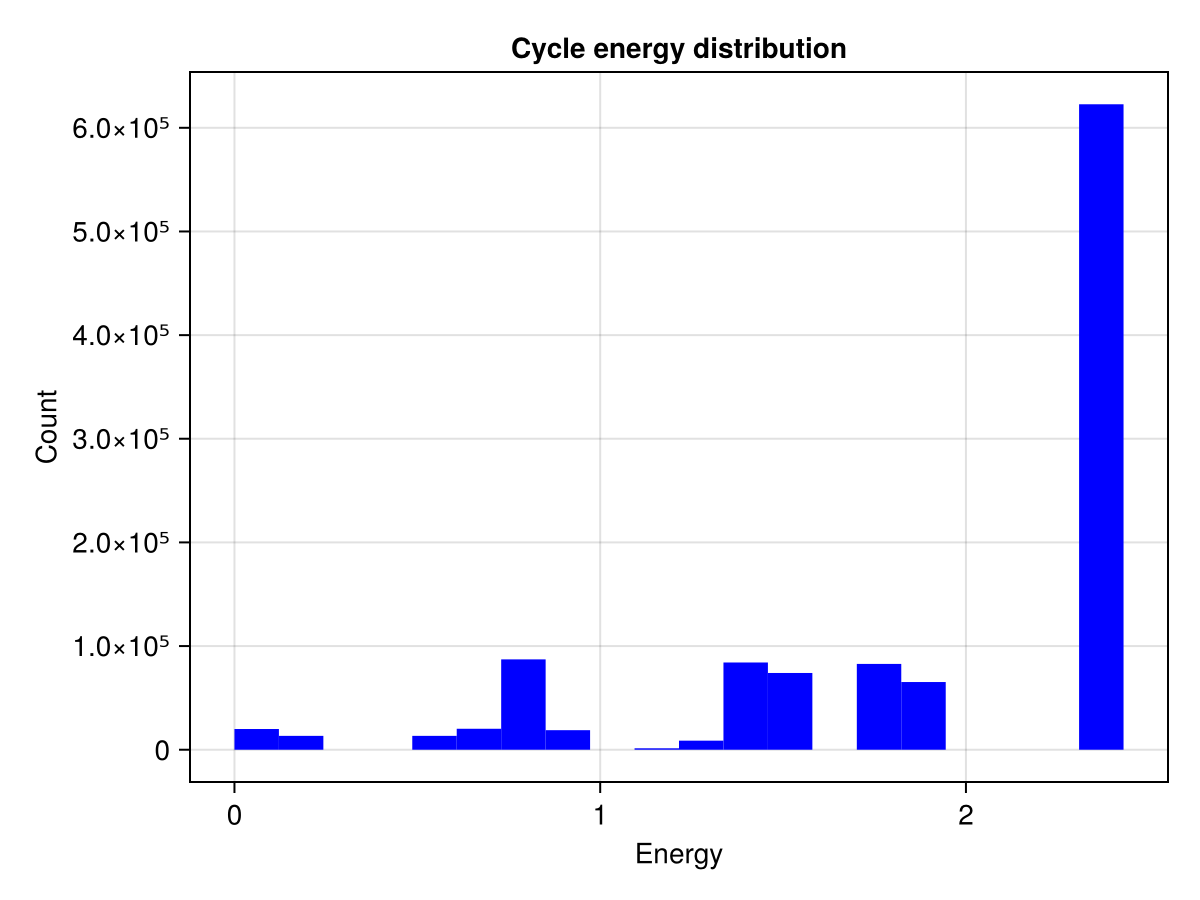

CairoMakie.Screen{IMAGE}


In [43]:
# histogram of cycle energies
fig = Figure()
ax = Axis(fig[1, 1]; title="Cycle energy distribution", xlabel="Energy", ylabel="Count")
hist!(ax, cycle_energy; color=:blue, bins=20)
display(fig)

In [28]:
fig = Figure()
ax = Axis(fig[1, 1]; title="Cycle energy distribution", xlabel="Energy", ylabel="Count")
hist!(ax, weights; color=:blue, bins=100)
display(fig)

MethodError: MethodError: no method matching fit(::Type{Histogram{Int64}}, ::MetaGraphsNext.MetaWeights{MetaGraph{Int64, SimpleDiGraph{Int64}, FGNodeType, Float64, Float64, @NamedTuple{Ns::Int64, Nr::Int64, mg::MetaGraph{Int64, SimpleDiGraph{Int64}, FGNodeType, @NamedTuple{name::String, val::Float64, desc::String}, Float64, @NamedTuple{Ns::Int64, Nr::Int64, ps::BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}, ss::Vector{Float64}}, typeof(identity), Float64}}, typeof(identity), Float64}, Float64}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
The function `fit` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  fit(!Matched::Type{D}, ::Any...) where D<:Distribution
   @ Distributions ~/.julia/packages/Distributions/YQSrn/src/genericfit.jl:47
  fit(::Type{Histogram{T}}, !Matched::AbstractVector, ::AbstractVector; closed) where T
   @ StatsBase ~/.julia/packages/StatsBase/s2YJR/src/hist.jl:298
  fit(!Matched::Type{Histogram}, ::Any...; kwargs...)
   @ StatsBase ~/.julia/packages/StatsBase/s2YJR/src/hist.jl:413
  ...
